In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd 'drive/My Drive/Airline'

/content/drive/My Drive/Airlines


# Supportvektormaschine

## Lade benötigte Pakete und Daten

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score, confusion_matrix, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report
import time

In [ ]:
train = pd.read_csv('data/train_set.csv')
train.shape

(102866, 23)

In [ ]:
train.head(5)

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,0,0,1,42,1,0,1304,2,4,4,4,2,2,2,2,3,3,4,2,4,2,0,0.0
1,1,0,1,57,1,2,844,1,1,1,1,2,4,5,4,4,4,4,4,4,3,18,19.0
2,1,0,1,39,1,0,1716,4,2,2,2,4,4,4,4,1,4,3,1,3,4,1,0.0
3,0,1,1,42,1,2,1177,2,5,3,5,3,4,4,2,2,2,2,2,2,2,11,19.0
4,1,1,1,39,1,2,2017,3,3,3,3,4,4,5,5,5,5,5,4,5,5,7,29.0


In [ ]:
train.columns

Index(['satisfaction', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes'],
      dtype='object')

Trenne Datensatz in Trainings- und Validierungsset. Verwende *random_state* für Reproduzierbarkeit.


In [ ]:
y = train['satisfaction']
X = train[['Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=32)

## Trainiere Modell

Erstelle zuerst Funktion für bequemeres Trainieren und trainiere danach ein Modell mit den *default*-Parametern:

In [ ]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    time_taken = round(time.time()-t0, 3)
    print("Time taken = {} seconds".format(time_taken))
    print("ROC_AUC = {}".format(roc_auc))
    print(classification_report(y_test,y_pred,digits=5))
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, roc_auc

Time taken = 550.682 seconds
ROC_AUC = 0.6132040112699614
              precision    recall  f1-score   support

           0    0.55012   0.67007   0.60420      9205
           1    0.67560   0.55634   0.61020     11369

    accuracy                        0.60722     20574
   macro avg    0.61286   0.61320   0.60720     20574
weighted avg    0.61946   0.60722   0.60752     20574



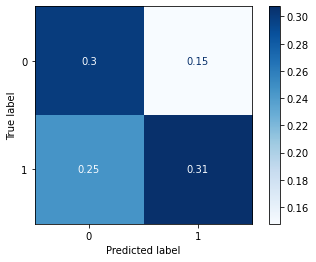

In [ ]:
params_svm = {}

model_svm = SVC(**params_svm)
model_svm, roc_auc_svm = run_model(model_svm, X_train, y_train, X_test, y_test)

###Hyperparameter-Optimierung (Bayesian)

Installiere Paket für *Bayesian Optimization*. Anschließend setzen wir die Grenzen der Hyperparametersuche und führen die Optimierung mit Kreuzvalidierung durch. Die Ergebnisse sind hier nur im Output der Zelle aufgeführt. Aufgrund der langen Rechendauer wurde die Optimierung nur einmal durchgeführt. Bei einer erneuten Optimierung wird ebenfalls eine JSON erstellt.

In [ ]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours
from sklearn.model_selection import cross_val_score

In [ ]:
def svc_cv(C, gamma, data, targets):

    estimator = SVC(C=C, gamma=gamma, random_state=2)
    cval = cross_val_score(estimator, data, targets, scoring='roc_auc', cv=4)
    return cval.mean()

In [ ]:
def optimize_svc(data, targets):
    
    def svc_crossval(expC, expGamma):
  
        C = 10 ** expC
        gamma = 10 ** expGamma
        return svc_cv(C=C, gamma=gamma, data=data, targets=targets)

    optimizer = BayesianOptimization(
        f=svc_crossval,
        pbounds={"expC": (-3, 2), "expGamma": (-4, -1)},
        random_state=1234,
        verbose=2
    )

    logger = JSONLogger(path="./svm_logs.json")
    optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

    optimizer.maximize(n_iter=5)

    print("Final result:", optimizer.max)

In [ ]:
optimize_svc(X, y)

|   iter    |  target   |   expC    | expGamma  |
-------------------------------------------------
|  1        |  0.7257   | -2.042    | -2.134    |
|  2        |  0.7617   | -0.8114   | -1.644    |
|  3        |  0.8968   |  0.8999   | -3.182    |
|  4        |  0.7636   | -1.618    | -1.594    |
|  5        |  0.7846   |  1.791    | -1.372    |
|  6        |  0.9154   |  2.0      | -4.0      |
|  7        |  0.8723   |  0.03059  | -4.0      |
|  8        |  0.754    | -3.0      | -1.0      |
Final result: {'target': 0.9154438935915313, 'params': {'expC': 2.0, 'expGamma': -4.0}}


### Trainiere neu mit optimierten Hyperparametern

Aufgrund der langen Rechenzeit wird die vielversprechendste Parameterkonfigurationen der Optimierung verwendet, um ein Modell zu trainieren und anschließend zu speichern.

Time taken = 754.09 seconds
ROC_AUC = 0.8464586199290035
              precision    recall  f1-score   support

           0    0.82409   0.83770   0.83084      9205
           1    0.86681   0.85522   0.86098     11369

    accuracy                        0.84738     20574
   macro avg    0.84545   0.84646   0.84591     20574
weighted avg    0.84770   0.84738   0.84749     20574



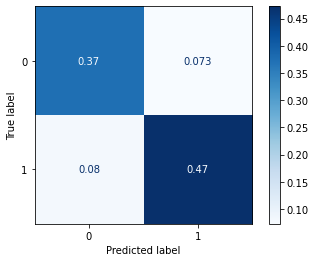

In [ ]:
params_svm = {'kernel': 'rbf',
         'C': 100,
         'gamma': 0.0001,
         'random_state': 42}

model_svm = SVC(**params_svm)
model_svm, roc_auc_svm = run_model(model_svm, X_train, y_train, X_test, y_test)

In [ ]:
# Save model
import pickle

In [ ]:
filename = 'export/svm_v1'
pickle.dump(model_svm, open(filename, 'wb'))

## Modellevaluation

Lade Testset und berechne anschließend für das trainierte Modell Genauigkeit und Fbeta(0,5)-Wert.

In [ ]:
test = pd.read_csv('data/test_set.csv')
test.shape

(25717, 23)

In [ ]:
y_test = test['satisfaction']
X_test = test[['Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Seat comfort',
       'Departure/Arrival time convenient', 'Food and drink', 'Gate location',
       'Inflight wifi service', 'Inflight entertainment', 'Online support',
       'Ease of Online booking', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding',
       'Departure Delay in Minutes', 'Arrival Delay in Minutes']]# Normalizing Features

In [ ]:
# Calculate Accuracy - v1
filename = 'export/svm_v1'
model_svm = pickle.load(open(filename, 'rb'))

result = model_svm.score(X_test, y_test)
print(result)

0.851537893222382


In [ ]:
# Calculate Fbeta - v1
y_pred = model_svm.predict(X_test)
fbeta = fbeta_score(y_test, y_pred, beta=0.5)
print("F(0.5) = {}".format(fbeta))

F(0.5) = 0.8689583723038405
